# Anomaly Detection in Finance Dataset (Credit Card Fraud)
#### Writer: Hamidreza Salahi
#### Date: July 2024 (Week 2)

## 1. Overview

Detecting fraudulent transactions in credit card datasets presents a significant challenge due to their rarity and potential financial impact.

### Dataset
 The dataset used in this notebook presents transactions that occurred in two days, where there are 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.17% of all transactions. The dataset is sourced from Kaggle (https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud).

### Assumption 
In this analysis, fraudulent transactions are treated as anomalies within the dataset.
### Goal
The primary objective of this study is to develop robust anomaly detection models capable of accurately identifying fraudulent activities. Achieving this goal involves comprehensive exploratory data analysis (EDA), rigorous feature engineering, and the application of advanced unsupervised learning techniques.

### Methodology
- $\textbf{Exploratory Data Analysis (EDA)}$: 
This initial phase aims to gain insights into the dataset's characteristics, including data quality checks such as handling null values and removing duplicates.

- $\textbf{Feature Engineering and Selection}$: 
Rigorous methods are employed to extract meaningful features and identify discriminative patterns crucial for distinguishing between legitimate and fraudulent transactions.


- $\textbf{Unsupervised Learning Techniques}$: 
Models such as Isolation Forest (IForest), K-Nearest Neighbors (KNN), and Local Outlier Factor (LOF) are applied to detect anomalies, leveraging the dataset's inherent imbalance.

- $\textbf{Evaluation Metric}$:
The performance of the anomaly detection models is evaluated using AUC PR (Area Under the Precision-Recall Curve), chosen for its effectiveness in assessing model performance in the context of highly imbalanced datasets.

### Experiments 
In addition to standard model training and evaluation, this study includes experimental analyses to explore the impact of different data preprocessing techniques, including various scaling methods:

   - StandardScaler
   - MinMaxScaler
   - RobustScaler
    
on model performance. Specifically, experiments were also conducted using:

 - A subsample maintaining the original ratio of fraudulent to genuine transactions.
 - Upsampled datasets to achieve a balanced ratio of fraudulent to genuine transactions.
 - Downsampled datasets for balanced class distribution.

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (roc_auc_score,confusion_matrix, ConfusionMatrixDisplay,precision_recall_curve,
                             average_precision_score,auc)
from pyod.models.knn import KNN  
from pyod.models.lof import LOF 
from pyod.models.iforest import IForest 

import itertools
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import shap
import pickle
from tqdm import tqdm
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


from sklearn.dummy import DummyClassifier


import warnings
warnings.filterwarnings("ignore")



## 2. Load datasets, EDA and Feature Engineering 

For this analysis, the **Credit Card Fraud Detection dataset** was selected from Kaggle. This dataset is a widely used benchmark for testing
anomaly detection algorithms due to its real-world nature and the challenge posed by its class
imbalance.

### 2.1 Load data

In [2]:
# Loading the dataset and Creating fraud dataframe

dataset_name = 'creditcard' 
df = pd.read_csv(dataset_name+'.csv')


### 2.2 EDA

In [17]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


- Observation: It seems that features V1-V28 are results of a PCA Dimensionality reduction to protect user identities and sensitive info.

### 2.2.1: Missing Values

In [18]:
# Check for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

- no missing values

### 2.2.2: Check for standardization

In [19]:
description = df.describe()
description

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


- Observation: The data is not standardized. min and max are not always (0, 1) therefore no MinMaxScaler is used. Mean and std are not always (0,1) so no StandardScaler is used either. 

In [20]:
# Extract min and max values from describe()
min_values = description.loc['min']
max_values = description.loc['max']

### 2.2.3: Check for duplicates

In [27]:
df.shape

(284807, 31)

In [28]:
duplicates = df[df.duplicated()]

In [29]:
print(f"There are {duplicates.shape[0]} duplicates in our dataframe which is {round(duplicates.shape[0]/df.shape[0],3)*100}% of the data")

There are 1081 duplicates in our dataframe which is 0.4% of the data


Let's check for duplicates in each class (fraudulent and genuine).

In [30]:
duplicates_class_0 = df[df.duplicated() & (df['Class'] == 0)]
duplicates_class_1 = df[df.duplicated() & (df['Class'] == 1)]

In [35]:
duplicates_class_0.shape

(1062, 31)

In [36]:
print(f" Out of {df[df['Class']==1].shape[0]} fraudulent transactions, there are {duplicates_class_1.shape[0]} duplicates which is {round(duplicates_class_1.shape[0]/df[df['Class']==1].shape[0],3)*100}% of the total fraudulent transactions")
print(f" Out of {df[df['Class']==0].shape[0]} genuine transactions, there are {duplicates_class_0.shape[0]} duplicates which is {round(duplicates_class_0.shape[0]/df[df['Class']==0].shape[0],3)*100}% of the total genuine transactions")


 Out of 492 fraudulent transactions, there are 19 duplicates which is 3.9% of the total fraudulent transactions
 Out of 284315 genuine transactions, there are 1062 duplicates which is 0.4% of the total genuine transactions


In [37]:
df.drop_duplicates(inplace=True)

### 2.2.4 Class imbalance

In [38]:
print(df['Class'].value_counts())

Class
0    283253
1       473
Name: count, dtype: int64


In [39]:
print(f"The {dataset_name} dataset has {round(df[df.Class==1].shape[0]/df.shape[0]*100,2) }% fraudulent transactions")

The creditcard dataset has 0.17% fraudulent transactions


- Observation: It is a highly imbalanced dataset with only 0.17% fraudulent transactions

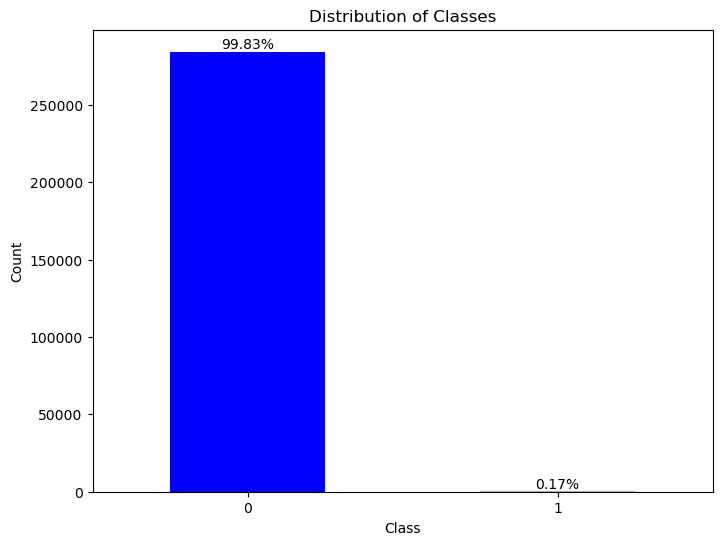

In [10]:
class_counts = df['Class'].value_counts()
total_counts = len(df)

plt.figure(figsize=(8, 6))
ax = class_counts.plot(kind='bar', color=['blue', 'orange'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Classes')
plt.xticks(rotation=0)

# Annotate bars with percentages
for i, count in enumerate(class_counts):
    percentage = (count / total_counts) * 100
    ax.text(i, count + 0.05, f'{percentage:.2f}%', ha='center', va='bottom')

plt.show()

## 2.3 Feature Selection

### 2.3.1 Features Distribution

The first step is to check if the distributions of fraudulent and genuine transactions are statistically significantly different for each column. The goal is to drop those columns which do not have significantly different distributions. To achieve this, I first perform a Shapiro-Wilk test for normality. Based on the results, I will then choose appropriate non-parametric tests to determine if the distributions of the features are significantly different between the two classes.

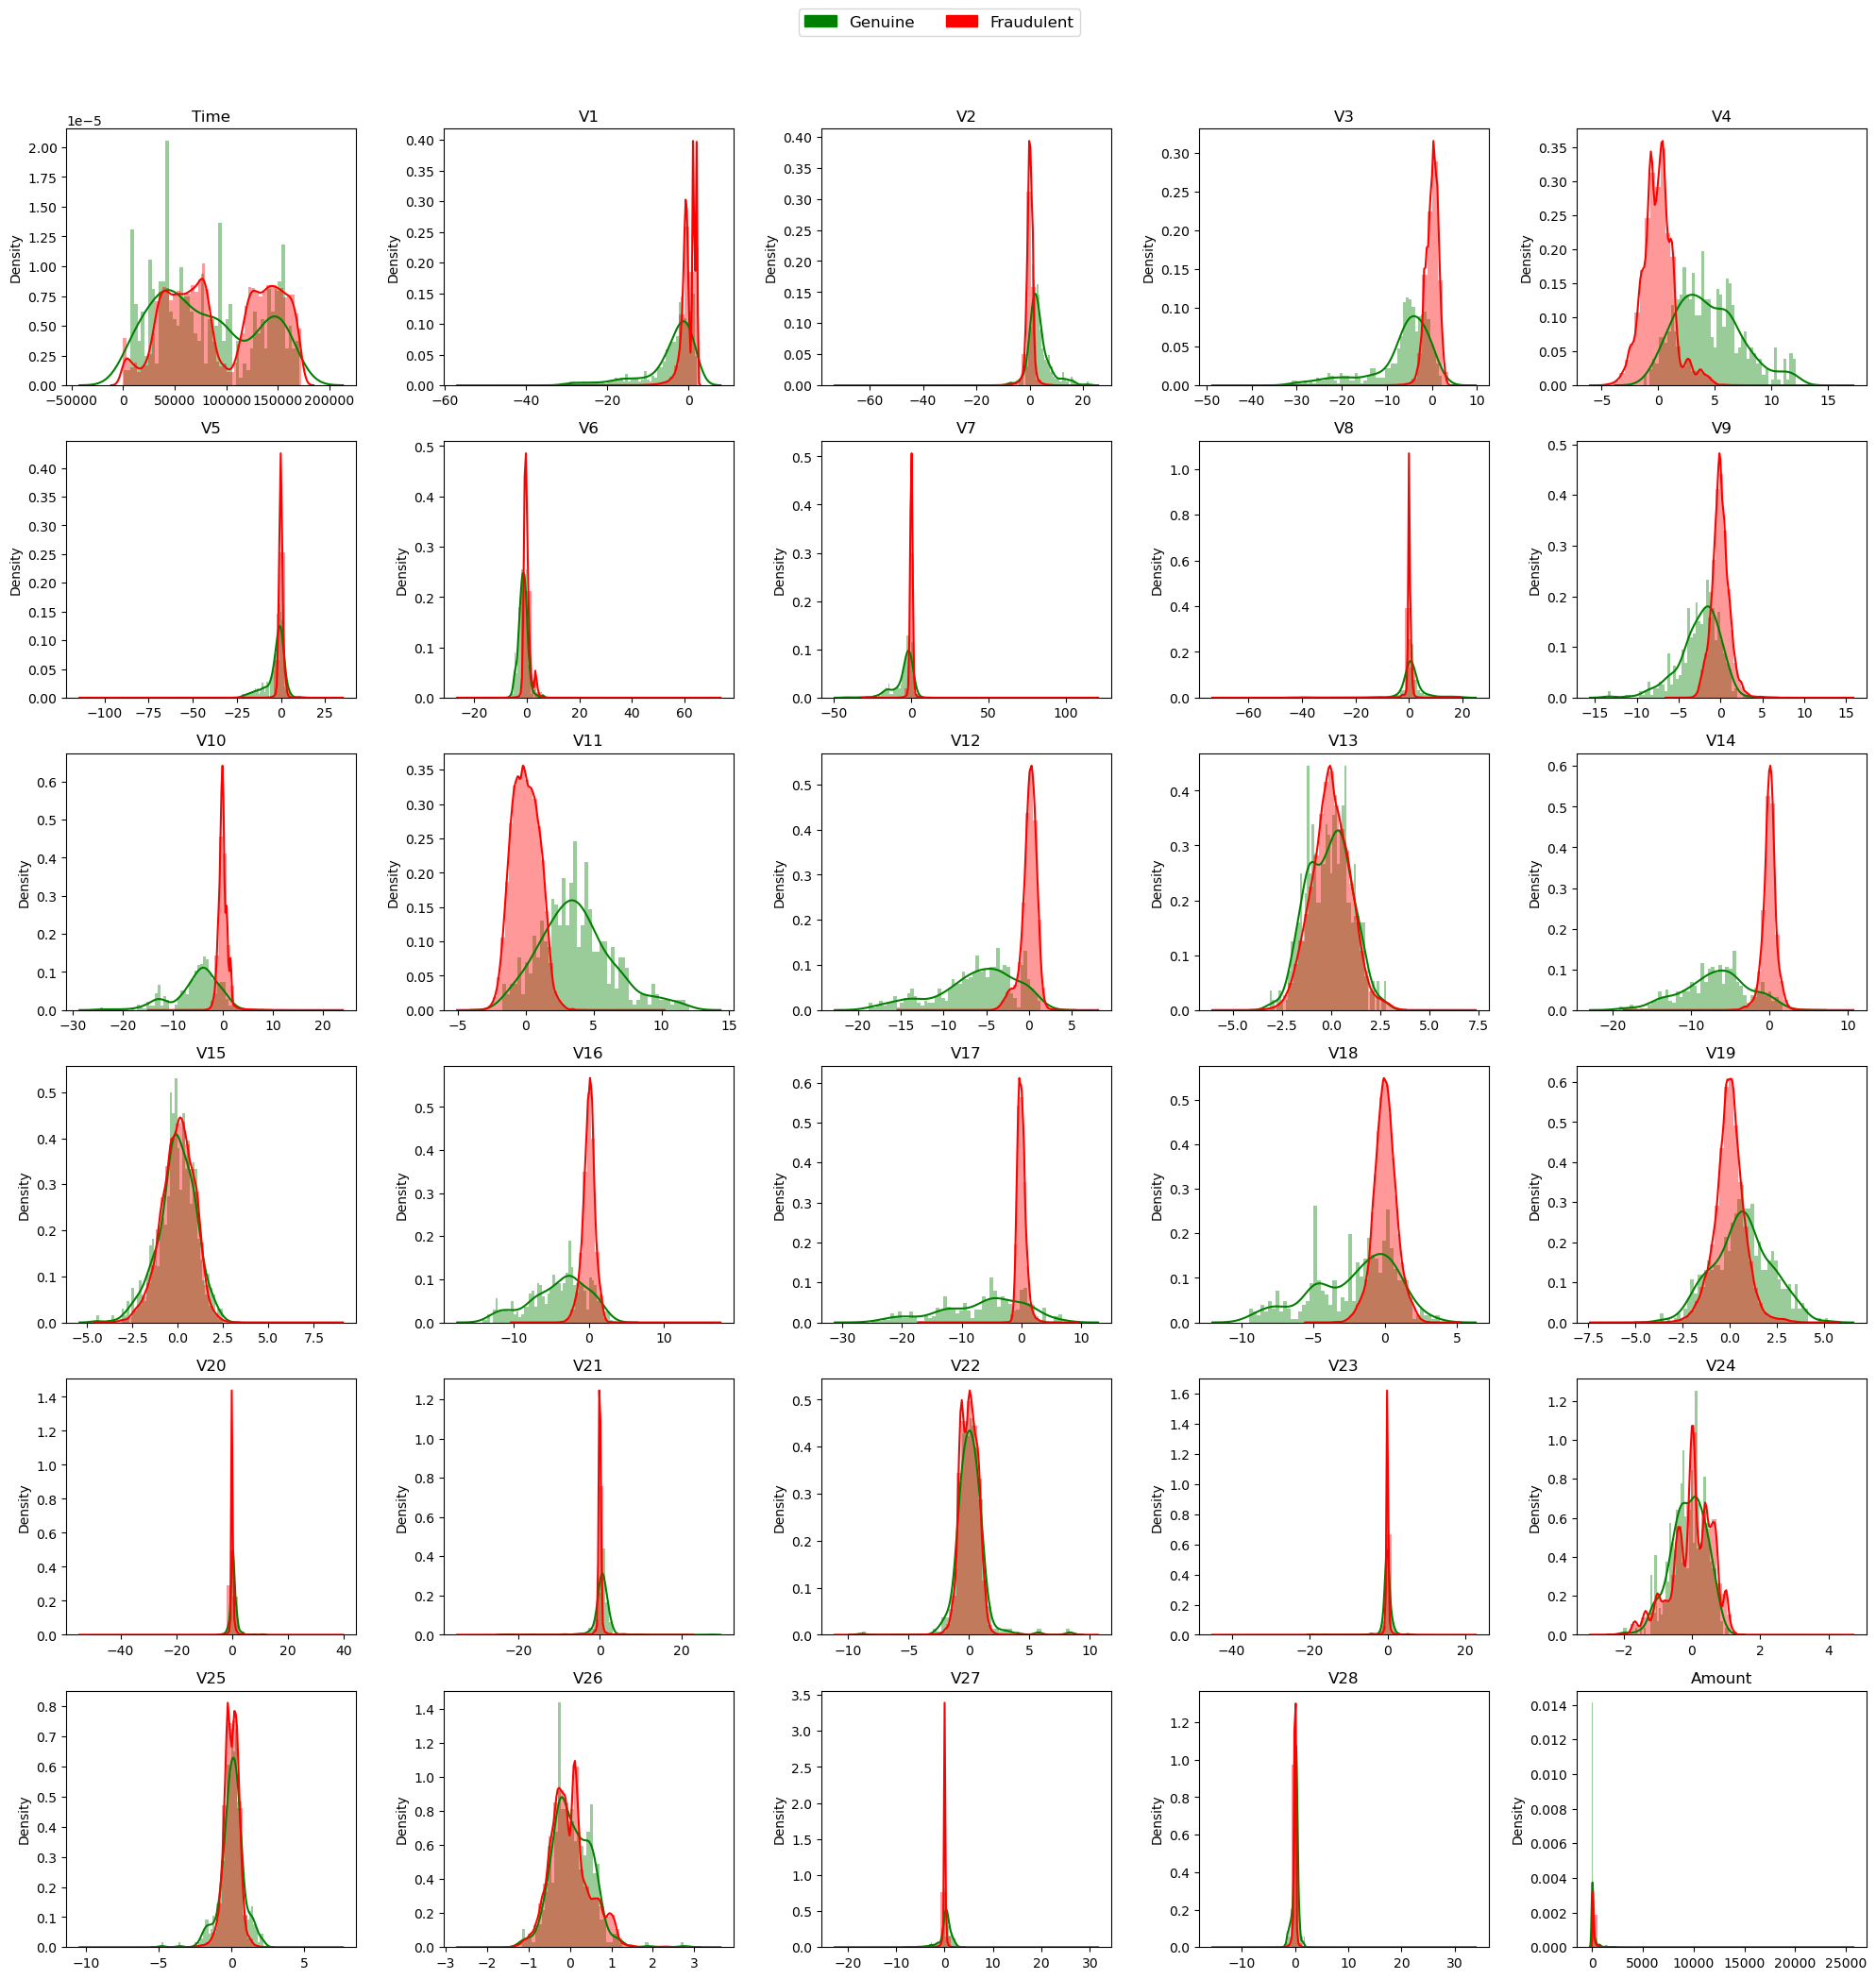

In [45]:
columns = df.drop('Class', axis=1).columns
grid = gridspec.GridSpec(6, 5)

plt.figure(figsize=(20, 10*2))

for n, col in enumerate(df[columns]):
    ax = plt.subplot(grid[n])
    sns.distplot(df[df.Class==1][col], bins=50, color='g', label='Genuine' if n == 0 else "")
    sns.distplot(df[df.Class==0][col], bins=50, color='r', label='Fraudulent' if n == 0 else "")
    ax.set_ylabel('Density')
    ax.set_title(str(col))
    ax.set_xlabel('')

genuine_patch = mpatches.Patch(color='green', label='Genuine')
fraudulent_patch = mpatches.Patch(color='red', label='Fraudulent')


plt.figlegend(handles=[genuine_patch, fraudulent_patch], loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.05), fontsize='large')

plt.tight_layout(rect=[0, 0, 1, 1])  
plt.savefig('Features_Distribution.png', dpi=300, bbox_inches='tight')

plt.show()

### Possible tests to do:
- t-Test: The data should be normally distributed, and the two samples should have equal variances
- Mann-Whitney U Test (Wilcoxon Rank-Sum Test): When comparing the medians of two independent samples, especially when the data is not normally distributed.
- Kolmogorov-Smirnov Test (KS Test): When comparing the cumulative distributions of two samples. It is non-parametric and can be used for any type of data distribution.
- ANOVA (Analysis of Variance): When comparing the means of three or more independent samples. The data should be normally distributed, and the samples should have equal variances.

### Check for normality - Shapiro–Wilk test

The null-hypothesis of this test is that the population is normally distributed. Thus, if the p value is less than the chosen alpha level, then the null hypothesis is rejected and there is evidence that the data tested are not normally distributed. On the other hand, if the p value is greater than the chosen alpha level, then the null hypothesis (that the data came from a normally distributed population) can not be rejected (e.g., for an alpha level of .05, a data set with a p value of less than .05 rejects the null hypothesis that the data are from a normally distributed population – consequently, a data set with a p value more than the .05 alpha value fails to reject the null hypothesis that the data is from a normally distributed population).

In [46]:
for col in columns:
    data1 = df[df.Class == 1][col].dropna()
    data2 = df[df.Class == 0][col].dropna()

    # Shapiro-Wilk test for normality
    stat1, p1 = shapiro(data1)
    stat2, p2 = shapiro(data2)
    print(f"Shapiro-Wilk test for {col} - Genuine: Statistic={stat1}, p-value={p1}")
    print(f"Shapiro-Wilk test for {col} - Fraudulent: Statistic={stat2}, p-value={p2}")

Shapiro-Wilk test for Time - Genuine: Statistic=0.9365816011476481, p-value=2.6347863194848826e-13
Shapiro-Wilk test for Time - Fraudulent: Statistic=0.9400424568078444, p-value=8.984788136703246e-119
Shapiro-Wilk test for V1 - Genuine: Statistic=0.7733420323620617, p-value=4.700017629364086e-25
Shapiro-Wilk test for V1 - Fraudulent: Statistic=0.8091367123639388, p-value=4.1461665852243897e-154
Shapiro-Wilk test for V2 - Genuine: Statistic=0.8908664051156875, p-value=7.995451312460099e-18
Shapiro-Wilk test for V2 - Fraudulent: Statistic=0.739747702193559, p-value=2.309639128488041e-164
Shapiro-Wilk test for V3 - Genuine: Statistic=0.8278539673458926, p-value=3.537062432389108e-22
Shapiro-Wilk test for V3 - Fraudulent: Statistic=0.943540572047769, p-value=4.579100442367149e-117
Shapiro-Wilk test for V4 - Genuine: Statistic=0.9728463508083461, p-value=1.0845682443134856e-07
Shapiro-Wilk test for V4 - Fraudulent: Statistic=0.9740093345881988, p-value=3.6898272178570808e-96
Shapiro-Wilk te

It can be seen from the p-values that most of the distributions are not normal.

### Mann-Whitney U Test

The Mann-Whitney U Test compares the medians of two independent samples and is suitable for continuous or ordinal data that do not follow a normal distribution.

I chose the Mann-Whitney U Test to determine if the distributions of the features are significantly different between the two classes. 

In [47]:
for col in columns:
    data1 = df[df.Class == 1][col]
    data2 = df[df.Class == 0][col]

    stat, p_value = mannwhitneyu(data1, data2)

    if p_value > 0.01:
        print(f"The two distributions for {col} are not significantly different.\n")

The two distributions for V13 are not significantly different.

The two distributions for V15 are not significantly different.

The two distributions for V22 are not significantly different.

The two distributions for V25 are not significantly different.



Therefore I drop these columns from the dataframe

In [48]:
drop_cols = ['V13', 'V15', 'V22', 'V25']
df.drop(columns=drop_cols,inplace=True)

### 2.3.2 Correlation and Multicollinearity

The goal here is to avoid keeping highly correlated features because they can introduce multicollinearity, which can affect the performance of the models.

### Multicollinearity

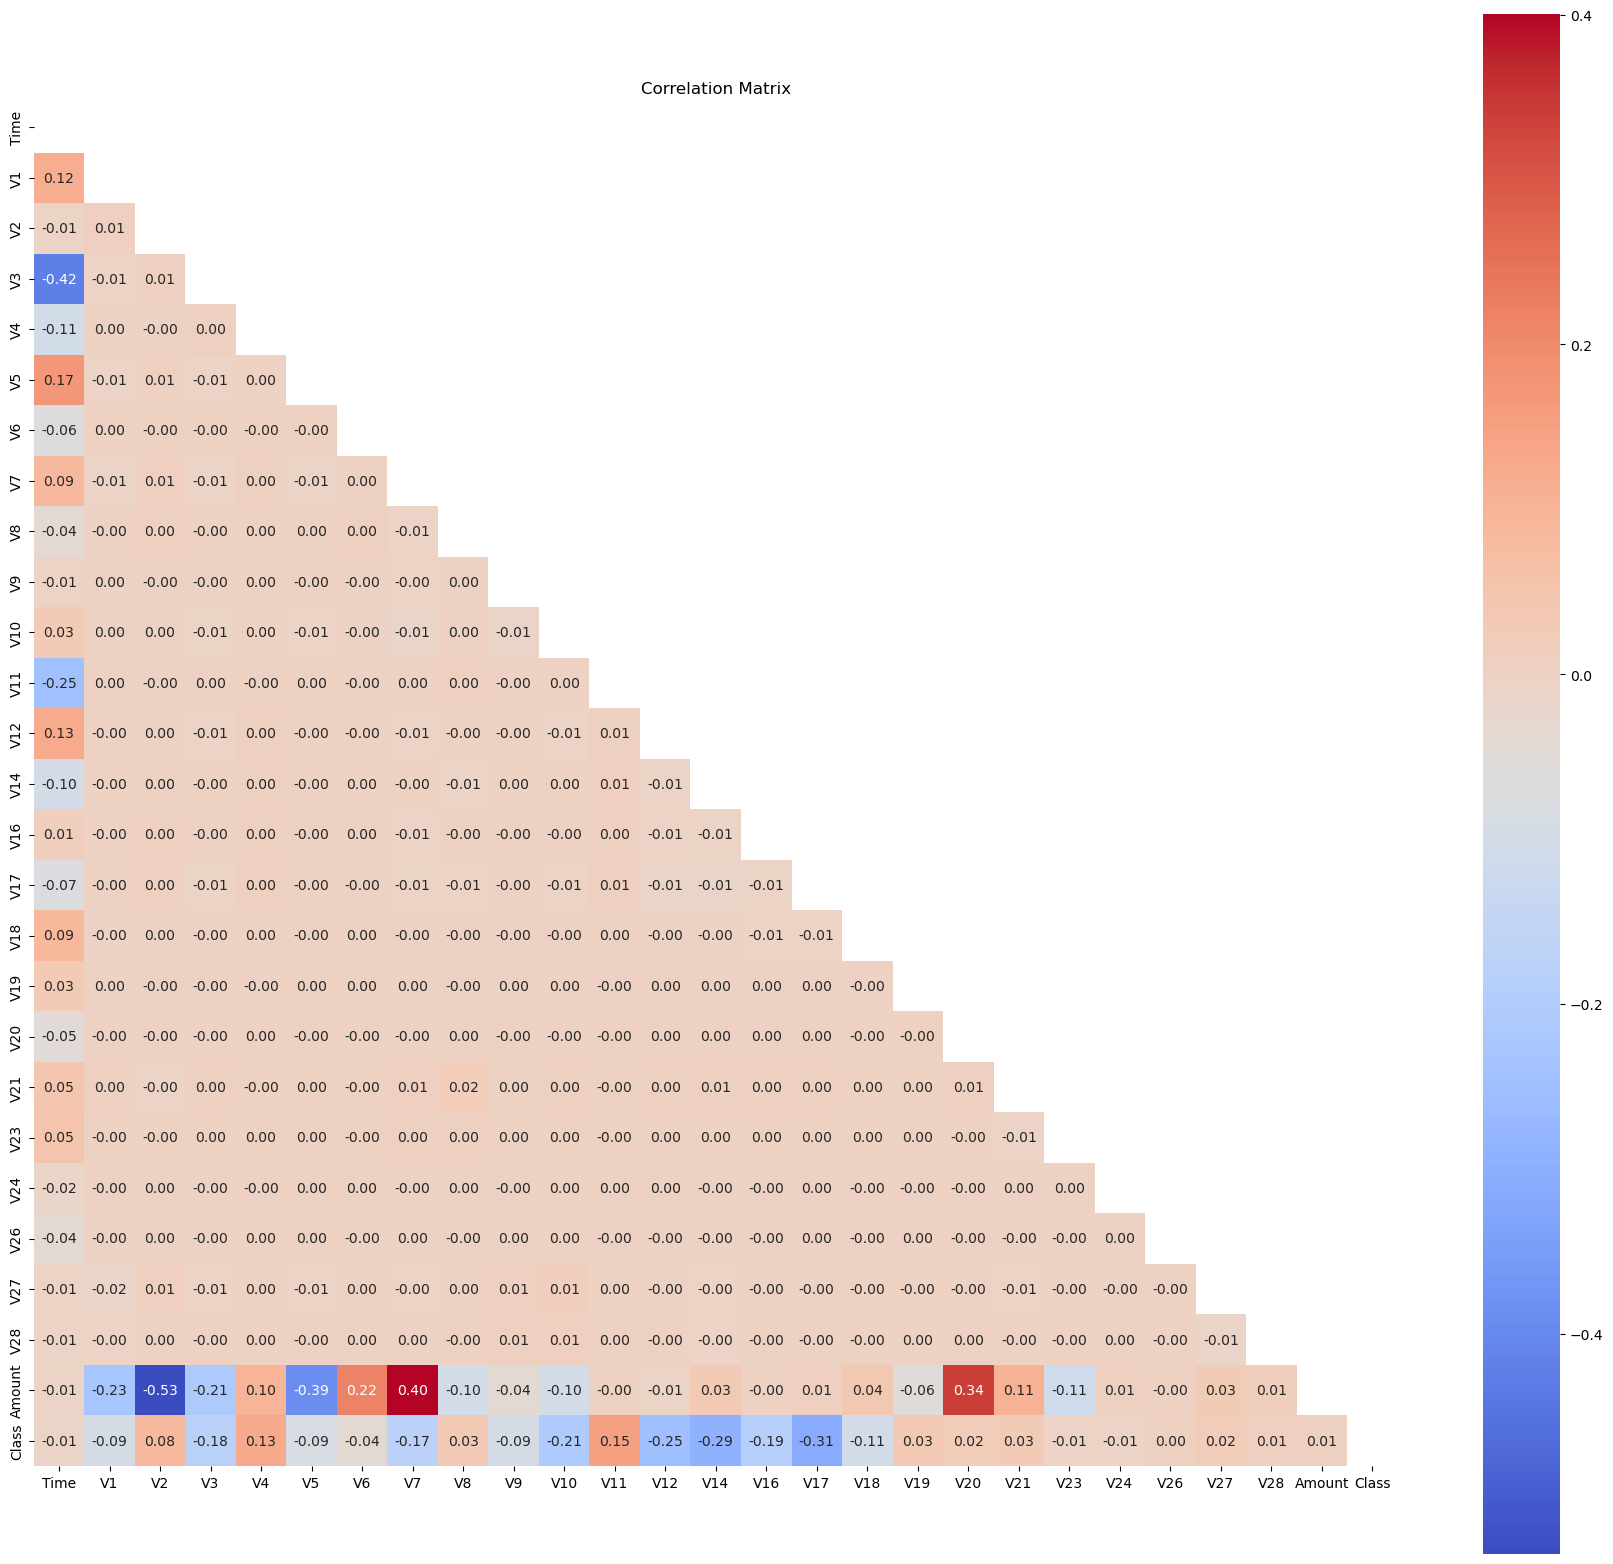

In [49]:
correlation_matrix = df.corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(22, 20))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)

plt.title('Correlation Matrix')
plt.show()

It seems that the features are not highly correlated with each other. On the other hand, there are features which have almost 0 correlation with the target column, "Class". I choose to drop the columns with less than 0.01 correlation with the target feature. 

### Correlation

The idea is to choose features that have a high absolute correlation value with the target class. I chose a correlation threshold of 0.01 between each feature and the target feature. Any feature with a correlation less than this threshold is eliminated.

In [50]:
target_correlation = correlation_matrix['Class'].drop('Class')


threshold = 0.01
drop_cols = target_correlation[target_correlation.abs() <= threshold].index
drop_cols

Index(['V23', 'V24', 'V26', 'V28', 'Amount'], dtype='object')

In [51]:
df.drop(columns=drop_cols, inplace=True)

### 2.3 Sub Sampling and train-test split

To manage computational expenses, I will use a subsample of 30,000 data points with the same distribution of fraudulent and genuine cases for hyperparameter tuning.

In [53]:
# Number of rows in the subsample
n_subsample = 30000

In [55]:
X = df.drop(columns=['Class'])
y = df['Class']
outliers = round(sum(y/len(y)*100),2)
print(f'The original {dataset_name} dataset has {len(y)} rows, {X.shape[1]} features and {outliers} % outliers')
data_combined = np.hstack((X, np.array(y).reshape(-1, 1)))  # Combine X and y to keep them together during sampling
subsampled_data = resample(data_combined, n_samples=n_subsample, stratify=y, random_state=42)  # Subsample the data while maintaining the class distribution
# Separate the subsample into features and target variable
X_subsample = subsampled_data[:, :-1]
y_subsample = subsampled_data[:, -1]
print(f'The subsample data has {X_subsample.shape[0]} rows, {X_subsample.shape[1]} features and {round(sum(y_subsample/len(y_subsample)*100),2)} % outliers')

The original creditcard dataset has 283726 rows, 21 features and 0.17 % outliers
The subsample data has 30000 rows, 21 features and 0.17 % outliers


In [255]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [256]:
X_train_subsample, X_test_subsample, y_train_subsample, y_test_subsample = train_test_split(X_subsample, y_subsample, test_size=0.3, stratify=y_subsample, random_state=42)

## 3. Modeling, Hyperparameters optimization and storing the best model 

Multiple unsupervised anomaly detection models are trained using the PyOD library. Hyperparameters for each model are optimized through manually performed grid search and cross-validation, as GridSearchCV is not consistent with unsupervised learning and ROC AUC scoring. After identifying the best set of hyperparameters, we evaluate each model using the AUC-ROC metric. The best-performing model for each dataset is saved for future analysis and comparison.

### 3.1 Defining Models

Models I considered for unsupervised learning:

- KNN
- LOF
- IForest

In [56]:
# Define the anomaly detection models and their hyperparameters
models = {
   
    'KNN': {
        'model': KNN,
        'params': {
            'n_neighbors': [ 10, 20, 30, 40],
            'method': ['largest', 'mean', 'median'],
            'contamination': [0.01, 0.05, 0.1]
        }
    },
        'LOF': {
        'model': LOF,
        'params': {
          'n_neighbors': [20, 30, 40, 50],
            'contamination': [0.01, 0.05, 0.1]

                }
    },
    'IForest': {
        'model': IForest,
        'params': {
            'n_estimators': [200, 300, 400],
            'max_features': [0.05, 0.1, 0.2],
            'contamination': [0.01, 0.05, 0.1]
        }
    }
    
}

## 3.2 Evaluation Metric: 
The performance of each anomaly detection model is evaluated
using the **Area Under the Precision-Recall Curve (AUC PR)**. AUC PR is chosen for its
effectiveness in assessing model performance in **highly imbalanced datasets**, such as the
credit card fraud dataset used in this analysis. AUC PR measures the trade-off between
precision and recall. In the context of highly imbalanced datasets, AUC PR provides a
more informative metric than AUC ROC.

Random Guessing PR AUC: 0.001
Random Guessing ROC AUC: 0.499
IForest PR AUC: 0.158
IForest ROC AUC: 0.952


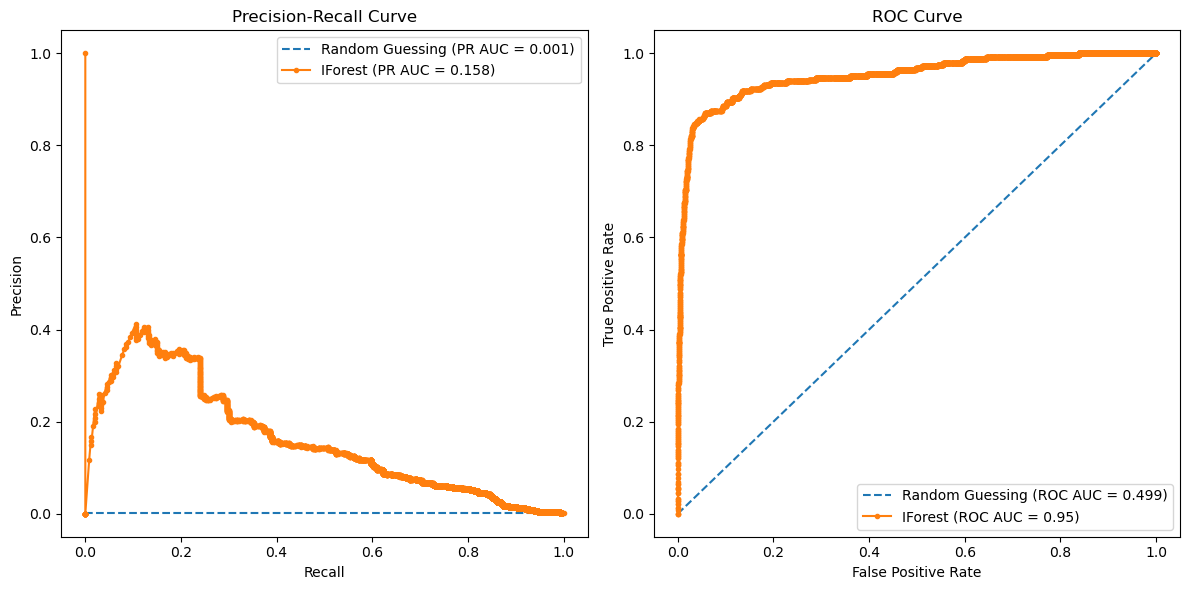

In [9]:
def plot_curves(test_y, model_probs, pr_auc, roc_auc, no_skill_pr_auc, no_skill_roc_auc):
    # Plot PR curve
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    no_skill = len(test_y[test_y == 1]) / len(test_y)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label=f'Random Guessing (PR AUC = {no_skill_pr_auc:.3f})')
    precision, recall, _ = precision_recall_curve(test_y, model_probs)
    plt.plot(recall, precision, marker='.', label=f'IForest (PR AUC = {pr_auc:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.title('Precision-Recall Curve')

    # Plot ROC curve
    plt.subplot(1, 2, 2)
    fpr, tpr, _ = roc_curve(test_y, model_probs)
    plt.plot([0, 1], [0, 1], linestyle='--', label=f'Random Guessing (ROC AUC = {no_skill_roc_auc:.3f})')
    plt.plot(fpr, tpr, marker='.', label=f'IForest (ROC AUC = {roc_auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.title('ROC Curve')

    plt.tight_layout()
    plt.show()


np.random.seed(0)
data_size = df.shape[0]

X = df.drop(columns=['Class'])
y = df['Class']

trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2, stratify=y)

# No skill model, stratified random class predictions
model = DummyClassifier(strategy='stratified')
model.fit(trainX, trainy)
yhat = model.predict_proba(testX)
naive_probs = yhat[:, 1]

# Calculate the PR-AUC and ROC-AUC for the no skill model
precision, recall, _ = precision_recall_curve(testy, naive_probs)
no_skill_pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(testy, naive_probs)
no_skill_roc_auc = roc_auc_score(testy, naive_probs)
print(f'Random Guessing PR AUC: {no_skill_pr_auc:.3f}')
print(f'Random Guessing ROC AUC: {no_skill_roc_auc:.3f}')

# Fit a IForest model
model = IForest()
model.fit(trainX)
yhat = model.predict_proba(testX)
model_probs = yhat[:, 1]

# Calculate the PR-AUC and ROC-AUC for the logistic regression model
precision, recall, _ = precision_recall_curve(testy, model_probs)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(testy, model_probs)
roc_auc = roc_auc_score(testy, model_probs)
print(f'IForest PR AUC: {pr_auc:.3f}')
print(f'IForest ROC AUC: {roc_auc:.3f}')

# Plot PR and ROC curves
plot_curves(testy, model_probs, pr_auc, roc_auc, no_skill_pr_auc, no_skill_roc_auc)


## 3.3 Baseline
**Original ratio of fraudulent to genuine transactions and no standardization**

### Hyperparameters optimization and storing the best model

In [258]:
# Evaluate the models
results = []

# Wrap the outer loop with tqdm for progress tracking
for model_name, model_info in tqdm(models.items(), desc="Evaluating models"):
    model_class = model_info['model']  # This should be the class, not an instance
    param_combinations = list(itertools.product(*(model_info['params'][param] for param in model_info['params'])))

    best_auc_roc = 0
    best_precision_score = 0
    best_pr_auc_score = 0
    best_model = None
    best_params = None

    for param_combination in param_combinations:
        params = {param: value for param, value in zip(model_info['params'].keys(), param_combination)}
        model = model_class(**params)

        # Manual cross-validation
        skf = StratifiedKFold(n_splits=5)
        auc_scores = []
        avg_precision_scores = []
        pr_auc_scores = []

        for train_index, val_index in skf.split(X_train_subsample, y_train_subsample):
            X_train_cv, X_val_cv = X_train_subsample[train_index], X_train_subsample[val_index]
            y_train_cv, y_val_cv = y_train_subsample[train_index], y_train_subsample[val_index]

            model.fit(X_train_cv)
            y_pred = model.decision_function(X_val_cv)

            auc_roc = roc_auc_score(y_val_cv, y_pred)
            auc_scores.append(auc_roc)
            
            avg_precision_score = average_precision_score(y_val_cv, y_pred)
            avg_precision_scores.append(avg_precision_score)
            
            precision, recall, _ = precision_recall_curve(y_val_cv, y_pred)
            pr_auc = auc(recall, precision)
            pr_auc_scores.append(pr_auc)

        avg_auc_roc = np.mean(auc_scores)
        avg_precision_score = np.mean(avg_precision_scores)
        avg_pr_auc = np.mean(pr_auc_scores)
        
        
       # Update best model if the current one is better
        if avg_pr_auc > best_pr_auc_score:
            best_pr_auc_score = avg_pr_auc
            best_model = model
            best_params = params

#         # Update best model if the current one is better
#         if avg_precision_score > best_precision_score:
#             best_precision_score = avg_precision_score
#             best_model = model
#             best_params = params
            
#         if avg_auc_roc > best_auc_roc:
#             best_auc_roc = avg_auc_roc
#             best_model = model
#             best_params = params

    y_pred_test = best_model.decision_function(X_test_subsample)
    test_auc_roc = roc_auc_score(y_test_subsample, y_pred_test)
    test_avg_precision = average_precision_score(y_test_subsample, y_pred_test)
    precision, recall, _ = precision_recall_curve(y_test_subsample, y_pred_test)
    test_pr_auc = auc(recall, precision)
    # Store the best model results
    results.append({
        'model': model_name,
        'best_params': best_params,
        'test_auc_roc': test_auc_roc,
        'test_avg_precision' : test_avg_precision,
        'test_pr_auc' : test_pr_auc,
        'best_model': best_model
    })

Evaluating models: 100%|█████████████████████████| 3/3 [18:27<00:00, 369.32s/it]


In [266]:
results_df = pd.DataFrame(results)
results_df = results_df[['model', 'test_avg_precision', 'test_auc_roc' ]].rename(columns={'test_avg_precision': 'avg_precision', 'test_auc_roc': 'auc_roc'})
results_df

,model,avg_precision,auc_roc
0,KNN,0.010285,0.780048
1,LOF,0.003700,0.649612
2,IForest,0.298890,0.919918


In [267]:
results_df.to_csv('results.csv', index=False)

## 4. Experiments

## 4.1 Effect of Standardization 

Different types of scaling I considered:

- StandardScaler
- MinMaxScaler
- RobustScaler

In [322]:
scalers = {
    'No Scaling': None,  # Placeholder for no scaling
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler(),
}

In [296]:
# Store results for each scaler in a list
results_originalRatio = []

# Outer loop for scalers
for scaler_name, scaler in tqdm(scalers.items(), desc="Comparing Scalers"):
    if scaler_name == 'No Scaling':
        X_train_scaled = X_train_subsample.copy()  # Use data without scaling
        X_test_scaled = X_test_subsample.copy()
    else:
        X_train_scaled = scaler.fit_transform(X_train_subsample)
        X_test_scaled = scaler.transform(X_test_subsample)

    # Evaluate models for this scaler
    for model_name, model_info in tqdm(models.items(), desc=f"Evaluating models with {scaler_name}", leave=False):
        best_auc_roc = 0
        best_precision_score = 0
        best_pr_auc_score = 0
        best_model = None
        best_params = None

        param_combinations = list(itertools.product(*(model_info['params'][param] for param in model_info['params'])))

        # Manual cross-validation
        skf = StratifiedKFold(n_splits=5)
        for param_combination in param_combinations:
            params = {param: value for param, value in zip(model_info['params'].keys(), param_combination)}
            model = model_info['model'](**params)

            auc_scores = []
            avg_precision_scores = []
            pr_auc_scores = []

            for train_index, val_index in skf.split(X_train_scaled, y_train_subsample):
                X_train_cv, X_val_cv = X_train_scaled[train_index], X_train_scaled[val_index]
                y_train_cv, y_val_cv = y_train_subsample[train_index], y_train_subsample[val_index]

                model.fit(X_train_cv)
                y_pred = model.decision_function(X_val_cv)

                auc_roc = roc_auc_score(y_val_cv, y_pred)
                auc_scores.append(auc_roc)

                avg_precision_score = average_precision_score(y_val_cv, y_pred)
                avg_precision_scores.append(avg_precision_score)

                precision, recall, _ = precision_recall_curve(y_val_cv, y_pred)
                pr_auc = auc(recall, precision)
                pr_auc_scores.append(pr_auc)

            avg_auc_roc = np.mean(auc_scores)
            avg_precision_score = np.mean(avg_precision_scores)
            avg_pr_auc = np.mean(pr_auc_scores)

            # Update best model if the current one is better
            if avg_pr_auc > best_pr_auc_score:
                best_pr_auc_score = avg_pr_auc
                best_model = model
                best_params = params

        # Evaluate on test set using the best model
        y_pred_test = best_model.decision_function(X_test_scaled)
        test_auc_roc = roc_auc_score(y_test_subsample, y_pred_test)
        test_avg_precision = average_precision_score(y_test_subsample, y_pred_test)
        precision, recall, _ = precision_recall_curve(y_test_subsample, y_pred_test)
        test_pr_auc = auc(recall, precision)

        # Store the results
        results_originalRatio.append({
            'scaler': scaler_name,
            'model': model_name,
            'best_params': best_params,
            'test_auc_roc': test_auc_roc,
            'test_avg_precision': test_avg_precision,
            'test_pr_auc': test_pr_auc,
            'best_model': best_model
        })


Comparing Scalers: 100%|██████████████████████| 4/4 [1:31:13<00:00, 1368.25s/it]


In [553]:

# Assuming 'results' contains the list of dictionaries with evaluation results
results_df = pd.DataFrame(results_originalRatio)

# Create a dictionary to store results by model and scaler
results_dict = {}

# Iterate over each row in the results dataframe
for index, row in results_df.iterrows():
    model = row['model']
    scaler = row['scaler']
    test_auc_roc = row['test_auc_roc']
    test_avg_precision = row['test_avg_precision']
    test_pr_auc = row['test_pr_auc']
    
    if scaler == 'No Scaling':
        continue
    # Initialize the model key if it doesn't exist
    if model not in results_dict:
        results_dict[model] = {}
    
    # Store the results under the model and scaler
    results_dict[model][scaler] = {
        'test_auc_roc': test_auc_roc,   
        'test_pr_auc': test_pr_auc
    }

# Create a dataframe from the dictionary
results_final_df = pd.DataFrame.from_dict({(model, scaler): results_dict[model][scaler] 
                                           for model in results_dict.keys() 
                                           for scaler in results_dict[model].keys()},
                                          orient='index')

# Rename the index levels for clarity
results_final_df.index.names = ['model', 'scaler']

# Function to highlight maximum values
def highlight_max(s):
    is_max = s == s.max()
    return ['font-weight: bold' if v else '' for v in is_max]

def highlight_max_numeric(s):
    if s.name != 'model':  # Skip 'model' column
        is_max = s == s.max()
        return ['font-weight: bold' if v else '' for v in is_max]
    else:
        return [''] * len(s)  # No styling for non-numeric 'model' column

    
# Display the styled dataframe for scaled models
styled_df = results_final_df.style.apply(highlight_max, axis=0)


# Display the styled dataframe for the baseline model

baseline_df = results_df.iloc[0:3][['model', 'test_auc_roc', 'test_pr_auc']]
baseline_df = baseline_df.reset_index(drop=True)
# Apply styling to highlight maximum values in each numeric column
styled_baseline_df = baseline_df.style.apply(highlight_max_numeric)



### Baseline model without any scaling

In [554]:
styled_baseline_df

,model,test_auc_roc,test_pr_auc
0,KNN,0.780048,0.007994
1,LOF,0.649612,0.003147
2,IForest,0.911846,0.235103


In [555]:
styled_baseline_df.to_excel('baselineResults_originalRatio.xlsx', engine='openpyxl')

### Models performance with different scalings

In [556]:
styled_df

In [557]:
styled_df.to_excel('results_originalRatio.xlsx', engine='openpyxl')

LOF clearly outperforms the other models by far. 

## 4.2 Upsampling and Downsampling

In [541]:
# Define SMOTE and RandomUnderSampler strategies
smote = SMOTE(random_state=42, sampling_strategy= 0.11)
rus = RandomUnderSampler(random_state=42, sampling_strategy=0.11)

# Function for SMOTE upsampling
def upsample_smote(X, y):
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return X_resampled, y_resampled

# Function for RandomUnderSampler downsampling
def downsample_random(X, y):
    X_resampled, y_resampled = rus.fit_resample(X, y)
    return X_resampled, y_resampled

In [542]:
X_train_upsamlpe, y_train_upsamlpe = upsample_smote(X_train_subsample, y_train_subsample)
print(f'The upsample data has {y_train_upsamlpe.shape} rows and {round(y_train_upsamlpe.sum()/len(y_train_upsamlpe),2)*100}% outliers')


The upsample data has (23271,) rows and 10.0% outliers


In [543]:
X_train_downsample, y_train_downsample = downsample_random(X_train, y_train)
print(f'The downsample data has {y_train_downsample.shape} rows and {round(y_train_downsample.sum()/len(y_train_downsample),2)*100}% outliers')


The downsample data has (3340,) rows and 10.0% outliers


In [544]:
# Store results for each scaler in a list
results_lof_pipeline = []

# Define models and scalers
models = {
    
    'LOF_downsampled': {
        'model': LOF,
        'params': {
            'n_neighbors': [10, 20, 30, 40],
            'contamination': [0.01, 0.05, 0.1]
        },
        'strategy': lambda X, y: downsample_random(np.array(X_train), np.array(y_train))  # Downsampling strategy
    },
    'LOF_upsampled': {
        'model': LOF,
        'params': {
            'n_neighbors': [10, 20, 30, 40],
            'contamination': [0.01, 0.05, 0.1]
        },
        'strategy': upsample_smote  # Upsampling strategy
    }
}

scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}

In [545]:
# Outer loop for scalers
for scaler_name, scaler in tqdm(scalers.items(), desc="Comparing Scalers"):
    # Outer loop for models
    for model_name, model_info in tqdm(models.items(), desc=f"Evaluating {scaler_name}", leave=False):

        best_pr_auc_score = 0
        best_model = None
        best_params = None

        param_combinations = list(itertools.product(*(model_info['params'][param] for param in model_info['params'])))

        # Iterate over parameter combinations
        for param_combination in param_combinations:
            params = {param: value for param, value in zip(model_info['params'].keys(), param_combination)}
            model_class = model_info['model']
            model = model_class(**params)

            # Select the strategy for this model
            strategy = model_info['strategy']

            # Perform upsampling or downsampling
            X_train_resampled, y_train_resampled = strategy(X_train_subsample, y_train_subsample)

            # Scale the resampled data
            X_train_scaled = scaler.fit_transform(X_train_resampled)
            X_test_scaled = scaler.transform(X_test_subsample)

            # Manual cross-validation
            skf = StratifiedKFold(n_splits=5)
            for train_index, val_index in skf.split(X_train_scaled, y_train_resampled):
                X_train_cv, X_val_cv = X_train_scaled[train_index], X_train_scaled[val_index]
                y_train_cv, y_val_cv = y_train_resampled[train_index], y_train_resampled[val_index]

                model.fit(X_train_cv)
                y_pred = model.decision_function(X_val_cv)

                precision, recall, _ = precision_recall_curve(y_val_cv, y_pred)
                pr_auc = auc(recall, precision)

                # Update best model if the current one is better
                if pr_auc > best_pr_auc_score:
                    best_pr_auc_score = pr_auc
                    best_model = model
                    best_params = params

        # Evaluate on test set using the best model
        y_pred_test = best_model.decision_function(X_test_scaled)
        test_auc_roc = roc_auc_score(y_test_subsample, y_pred_test)
        test_avg_precision = average_precision_score(y_test_subsample, y_pred_test)
        precision, recall, _ = precision_recall_curve(y_test_subsample, y_pred_test)
        test_pr_auc = auc(recall, precision)

        # Store the results
        results_lof_pipeline.append({
            'scaler': scaler_name,
            'model': model_name,
            'best_params': best_params,
            'test_auc_roc': test_auc_roc,
            'test_avg_precision': test_avg_precision,
            'test_pr_auc': test_pr_auc,
            'best_model': best_model
        })

Comparing Scalers: 100%|█████████████████████████| 3/3 [17:06<00:00, 342.23s/it]


In [637]:

# Assuming 'results' contains the list of dictionaries with evaluation results
results_lof_df = pd.DataFrame(results_lof_pipeline)

# Create a dictionary to store results by model and scaler
results_lof_dict = {}

# Iterate over each row in the results dataframe
for index, row in results_lof_df.iterrows():
    model = row['model']
    scaler = row['scaler']
    test_auc_roc = row['test_auc_roc']
    test_avg_precision = row['test_avg_precision']
    test_pr_auc = row['test_pr_auc']
    
    # Initialize the model key if it doesn't exist
    if model not in results_lof_dict:
        results_lof_dict[model] = {}
    
    # Store the results under the model and scaler
    results_lof_dict[model][scaler] = {
        'test_auc_roc': test_auc_roc,
      
        'test_pr_auc': test_pr_auc
    }

# Create a dataframe from the dictionary
results_lof_final_df = pd.DataFrame.from_dict({(model, scaler): results_lof_dict[model][scaler] 
                                           for model in results_lof_dict.keys() 
                                           for scaler in results_lof_dict[model].keys()},
                                          orient='index')

# Rename the index levels for clarity
results_lof_final_df.index.names = ['model', 'scaler']

# Function to highlight maximum values
def highlight_max(s):
    is_max = s == s.max()
    return ['font-weight: bold' if v else '' for v in is_max]


    
# Display the styled dataframe for scaled models
styled_lof_df = results_lof_final_df.style.apply(highlight_max, axis=0)

lof_df_withoutResample = results_final_df.iloc[3:6]
concatenated_df = pd.concat([results_lof_final_df, lof_df_withoutResample]).rename(columns={'test_auc_roc': 'test AUC ROC', 'test_pr_auc': 'test AUC PR'})
concatenated_df.style.apply(highlight_max, axis=0)
LOF_result = concatenated_df.rename(index={'LOF': 'LOF without resampling', 'LOF_downsampled': 'LOF downsampled', 'LOF_upsampled': 'LOF upsampled'}).style.apply(highlight_max, axis=0)
LOF_result

In [638]:
LOF_result.to_excel('LOFResults_Resample.xlsx', engine='openpyxl')

# End